In [ ]:
#Step 0) Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

In [ ]:
#Step 1) Data Cleaning & Pair Selection Process

#1a) load in dataset
df = pd.read_csv("/content/drive/MyDrive/Academics/Senior (2025-2026)/Fall 2025/CSCI4900_Data Science Capstone/clean_sp_500.csv")

#1b) Rename first column to "Ticker", remove "US EQUITY"
df = df.rename(columns={df.columns[0]: "Ticker"})
df["Ticker"] = df["Ticker"].str.replace(" US EQUITY", "", regex=False)

#1c) Transpose so dates are the rows, and tickers the columns
df = df.set_index("Ticker").T

#1d) Convert dates from string to dates and sort
df.index = pd.to_datetime(df.index, format="%m/%d/%y", errors="coerce")
df = df[df.index.notna()].sort_index()

#1e) Print
print(f"Cleaned Dataset (dates,stocks): {df.shape}")
print(df.head())

Cleaned Dataset (dates,stocks): (2697, 455)
Ticker          A     AAPL   ABBV    ABT     ACGL    ACN    ADBE     ADI  \
2015-01-05  39.80  26.5625  64.65  44.91  19.3800  87.34  71.980  54.525   
2015-01-06  39.18  26.5650  64.33  44.40  19.4233  86.71  70.530  53.250   
2015-01-07  39.70  26.9375  66.93  44.76  19.5367  88.53  71.110  53.810   
2015-01-08  40.89  27.9725  67.63  45.68  19.8767  89.88  72.915  54.760   
2015-01-09  40.59  28.0025  65.78  45.20  19.7033  89.78  71.840  54.720   

Ticker        ADM     ADP  ...       WTW     WY    WYNN    XEL    XOM    XYL  \
2015-01-05  50.22  83.230  ...  117.1653  36.11  144.39  35.71  90.29  35.71   
2015-01-06  49.23  82.535  ...  116.5825  36.07  141.31  35.90  89.81  35.50   
2015-01-07  49.97  83.260  ...  118.2513  36.18  145.46  36.21  90.72  35.78   
2015-01-08  49.24  85.170  ...  119.6023  36.57  147.21  36.63  92.23  36.05   
2015-01-09  48.82  84.560  ...  118.5427  36.52  149.05  36.18  92.10  35.37   

Ticker          YU

In [ ]:
#Step 2) Calculating Daily, Beta-adjusted Returns:
#2a) Daily returns
returns = df.pct_change().dropna()

#2b). Equal-weighted market return
market_ret = returns.mean(axis=1)

#2c). Simplified beta-adjusted returns: r_adj = r_i - r_market
returns_adj = returns.subtract(market_ret, axis=0)

#2d) Print Results
print("Daily, Beta-adjusted returns:")
print(returns_adj.head())

#2e.) data split/partioning
n = len(returns_adj)
train_ret = returns_adj.iloc[:int(n * 0.7)]
val_ret   = returns_adj.iloc[int(n * 0.7):int(n * 0.9)]
test_ret  = returns_adj.iloc[int(n * 0.9):]

print(f"Train shape: {train_ret.shape}")
print(f"Val shape:   {val_ret.shape}")
print(f"Test shape:  {test_ret.shape}")

Daily, Beta-adjusted returns:
Ticker             A      AAPL      ABBV       ABT      ACGL       ACN  \
2015-01-06 -0.006408  0.009264  0.004220 -0.002186  0.011404  0.001956   
2015-01-07  0.000610  0.001360  0.027754 -0.004554 -0.006824  0.008327   
2015-01-08  0.011494  0.019941 -0.008022  0.002073 -0.001078 -0.003232   
2015-01-09  0.000454  0.008863 -0.019564 -0.002717 -0.000933  0.006678   
2015-01-12 -0.004382 -0.017197  0.007140  0.015851  0.004398  0.004436   

Ticker          ADBE       ADI       ADM       ADP  ...       WTW        WY  \
2015-01-06 -0.010975 -0.014214 -0.010544  0.000819  ...  0.004195  0.008062   
2015-01-07 -0.004439 -0.002146  0.002369 -0.003878  ...  0.001652 -0.009613   
2015-01-08  0.006902 -0.000826 -0.033090  0.004459  ... -0.007056 -0.007702   
2015-01-09 -0.006953  0.007060 -0.000739  0.000628  ... -0.001069  0.006423   
2015-01-12 -0.002579 -0.002608 -0.005051  0.002536  ... -0.001495  0.008813   

Ticker          WYNN       XEL       XOM       XYL

In [ ]:
#Step 3) Correlation and Pair Selection Process
#3a) correlation matrix
corr_matrix = train_ret.corr()

#3b) Initialize list to store unique pairs
pairs = []

#3c) Loop through each unique pair only once
tickers = corr_matrix.columns
for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):  # skip duplicates
        t1 = tickers[i]
        t2 = tickers[j]
        corr = corr_matrix.loc[t1, t2]
        pairs.append((t1, t2, corr))

#3d) Convert to DataFrame and sort
top_corr = pd.DataFrame(pairs, columns=["Ticker1", "Ticker2", "Correlation"])
top_corr = top_corr.sort_values(by="Correlation", ascending=False)
top_corr = top_corr.reset_index(drop=True)

#3d) use top 40 pairs
top_n = 40
top_pairs = top_corr.head(top_n)

#3d) chosen pair: Fifth Third Bancorp (FITB), and Regionals Financial Corp (RF)
pair_corr = corr_matrix.loc["FITB", "RF"]

#3d) print results
print(top_pairs)
print(f"\n Correlation of FITB and RF: {pair_corr:.4f} ")

   Ticker1 Ticker2  Correlation
0     GOOG   GOOGL     0.987290
1      NWS    NWSA     0.950159
2      CMS     XEL     0.898187
3      CMS     LNT     0.885024
4      CMS     WEC     0.883877
5      WEC     XEL     0.878334
6      AEE     CMS     0.867566
7      LNT     XEL     0.867308
8       ES     WEC     0.866698
9      LNT     WEC     0.865779
10     AEP     CMS     0.862461
11     FRT     REG     0.861599
12      ED     WEC     0.854601
13     AEP     LNT     0.854265
14     AEE     XEL     0.852525
15     AEE     LNT     0.850318
16     AEP     XEL     0.848565
17     CMS      ED     0.845145
18    NCLH     RCL     0.844162
19     AEE     WEC     0.841999
20     AVB     UDR     0.840431
21      ES     XEL     0.840187
22     KEY      RF     0.839450
23     AEP     WEC     0.836162
24     CMS      ES     0.836002
25     ESS     UDR     0.834588
26     EQR     UDR     0.832357
27     CMS     DUK     0.831084
28      ES     LNT     0.830496
29     AVB     EQR     0.830024
30      

In [ ]:
#Step 4) OLS Regression and Spread Calculation
#4a) Chosen Stock Pair
T1, T2 = "FITB", "RF"

#4b) Extract returns
y = train_ret[T1]
x = train_ret[T2]

pair_df = pd.concat([x, y], axis=1)
pair_df.columns = [T2, T1]

#4c) Fit linear regression: y = alpha + beta * x
X = pair_df[[T2]].values  # RF
Y = pair_df[T1].values    # FITB

#4d) run regression using sklearn
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, Y)

#4e) Get alpha (y-int) and beta (slope coeff.)
alpha = model.intercept_
beta = model.coef_[0]

#4f) Calculate Predicted T1(FITB) and spread (actual-predicted)
pair_df["Predicted"] = model.predict(X)
pair_df["Spread"] = pair_df[T1] - pair_df["Predicted"]

#4g) Print results
print(f"OLS regression: {T1} = {alpha:.4f} + {beta:.4f} × {T2}")
print("Spread sample:")
print(pair_df[['Spread']].head())

OLS regression: FITB = -0.0000 + 0.8028 × RF
Spread sample:
              Spread
2015-01-06 -0.011570
2015-01-07  0.003793
2015-01-08  0.006798
2015-01-09 -0.001928
2015-01-12  0.001860


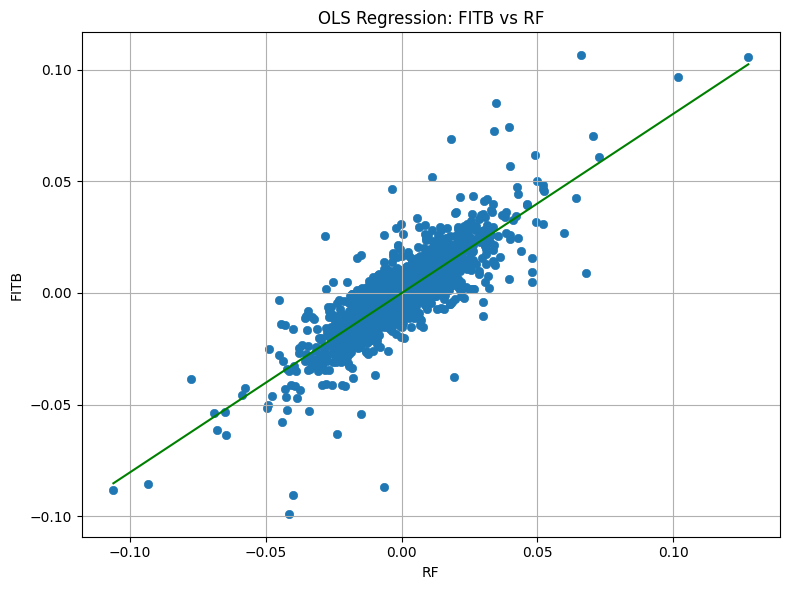

In [ ]:
#Step 5) scatterplot of OLS regression and line of best fit
#5a) Scatter of actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pair_df["RF"], y=pair_df["FITB"], alpha=1.0, edgecolor=None)

#5b) Regression line
sns.lineplot(x=pair_df["RF"], y=pair_df["Predicted"], color="green")

#5c) Labels
plt.title("OLS Regression: FITB vs RF")
plt.xlabel("RF")
plt.ylabel("FITB")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Step 6) Calculate rolling mean and std dev of the spread (z-score)
window = 100  # 100-day rolling window

# 6a) Rolling mean of spread
pair_df["mean"] = pair_df["Spread"].rolling(window).mean()

# 6b) Rolling standard deviation of spread
pair_df["std"] = pair_df["Spread"].rolling(window).std()

# 6c) Z-score = (spread - mean) / std
pair_df["z_score"] = (pair_df["Spread"] - pair_df["mean"]) / pair_df["std"]

# 6d) Show sample
print(pair_df[["FITB","RF","Spread", "mean", "std", "z_score"]].dropna())

                FITB        RF    Spread      mean       std   z_score
2015-05-29 -0.011254 -0.006975 -0.005618  0.000259  0.008298 -0.708278
2015-06-01 -0.010730 -0.012986 -0.000269  0.000372  0.008212 -0.078110
2015-06-02  0.013200  0.016020  0.000374  0.000338  0.008205  0.004422
2015-06-03  0.010811  0.014792 -0.001029  0.000260  0.008180 -0.157479
2015-06-04 -0.002952  0.000462 -0.003288  0.000246  0.008185 -0.431782
...              ...       ...       ...       ...       ...       ...
2022-06-28  0.013358  0.018353 -0.001341 -0.000978  0.008279 -0.043889
2022-06-29 -0.012380 -0.004076 -0.009072 -0.001064  0.008319 -0.962671
2022-06-30 -0.011281 -0.018918  0.003942 -0.001052  0.008325  0.599807
2022-07-01 -0.004616  0.003175 -0.007129 -0.001256  0.008220 -0.714556
2022-07-05 -0.000597 -0.005919  0.004190 -0.001238  0.008230  0.659556

[1788 rows x 6 columns]


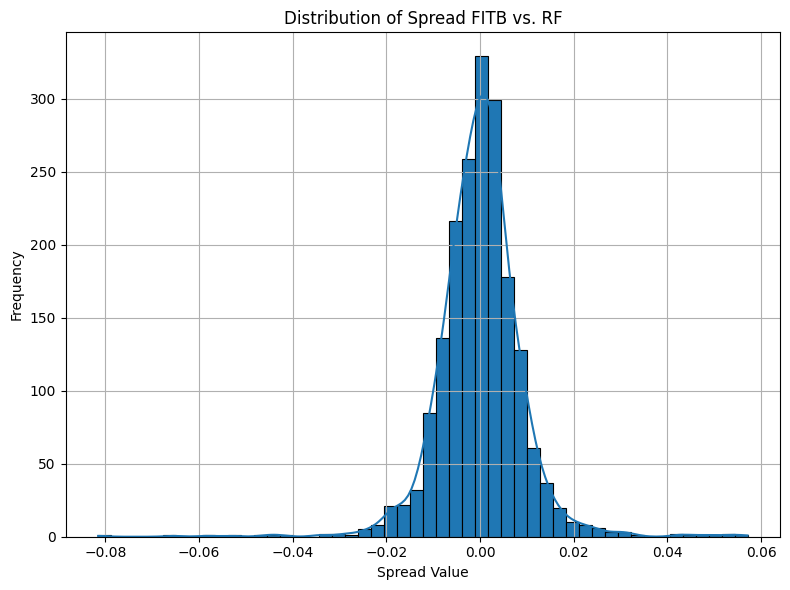

In [ ]:
#Step 7) Distribution of Spread E[T1-beta*T2] = 0
plt.figure(figsize=(8, 6))
sns.histplot(pair_df["Spread"].dropna(), bins=50, kde=True, alpha=1.0)


#7a) Add labels and formatting
spread_mean = pair_df["Spread"].mean()
spread_std = pair_df["Spread"].std()

#7b) plot
plt.title(f"Distribution of Spread {T1} vs. {T2}")
plt.xlabel("Spread Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend
plt.tight_layout()
plt.show()

In [ ]:
# Step 8) Generate trading signals based on z-score
#8a) established rule to enter a trade
entry_threshold = 1.1
exit_threshold = 0.5

signal = []
position = 0  # 1 = long, -1 = short, 0 = flat

#8b) Loop through each trading day spread z-score
for z in pair_df["z_score"]:
    if position == 0:
        if z <= -entry_threshold:
            position = 1   # Long the spread
        elif z >= entry_threshold:
            position = -1  # Short the spread
    elif position == 1:
        if z >= -exit_threshold:
            position = 0
    elif position == -1:
        if z <= exit_threshold:
            position = 0
    signal.append(position)

pair_df["signal"] = signal

#8c) Preview signal column
active_trades = pair_df[pair_df['signal']!= 0]
print(active_trades[['z_score','signal']])

             z_score  signal
2015-06-22  1.910932      -1
2015-07-01  1.441085      -1
2015-07-06  1.710057      -1
2015-07-08  1.107624      -1
2015-07-17  1.527748      -1
...              ...     ...
2022-05-20 -0.502320       1
2022-05-26  1.221277      -1
2022-06-06  1.425904      -1
2022-06-14  1.184467      -1
2022-06-17  1.955413      -1

[395 rows x 2 columns]


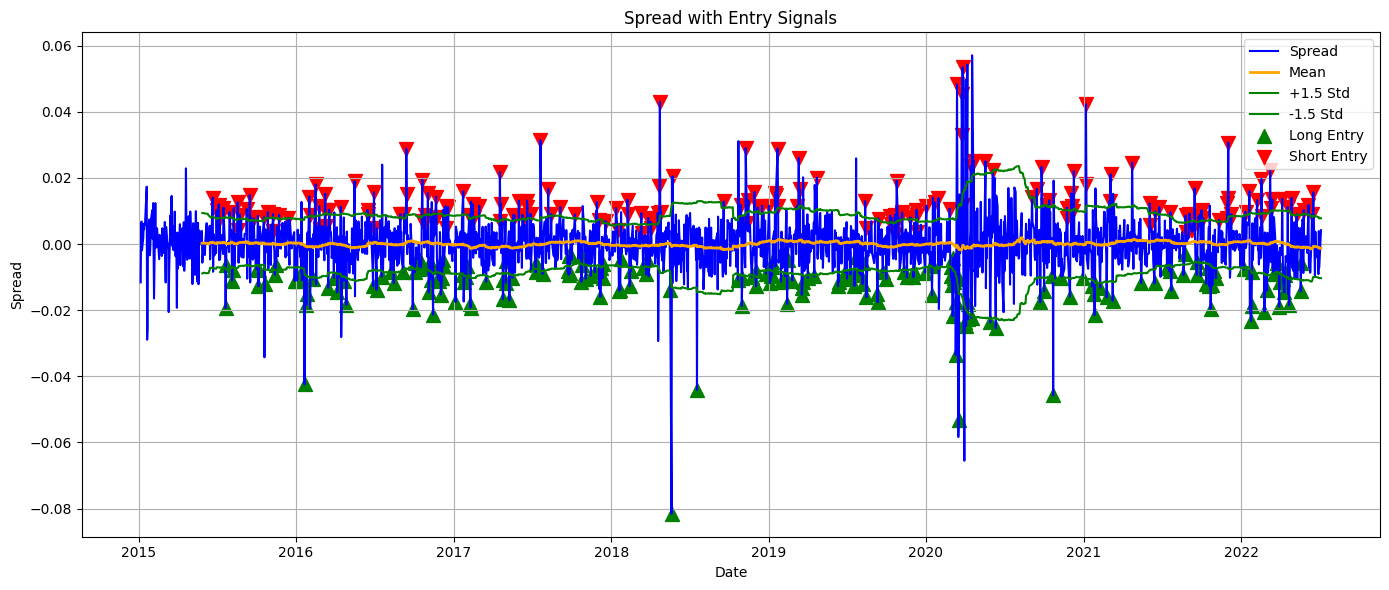

In [ ]:
#Step 9) (Continued) Trade Entry/Exit Visualizer
#9a) Create bands


upper_band = pair_df["mean"] + 1.1 * pair_df["std"]
lower_band = pair_df["mean"] - 1.1 * pair_df["std"]

#9b) Plot setup
plt.figure(figsize=(14,6))
plt.plot(pair_df.index, pair_df["Spread"], label="Spread", color="blue")
plt.plot(pair_df.index, pair_df["mean"], label="Mean", color="orange", linewidth=2)
plt.plot(pair_df.index, upper_band, label="+1.5 Std", color="green")
plt.plot(pair_df.index, lower_band, label="-1.5 Std", color="green")

#9c) Add entry signal markers
long_signals = pair_df[pair_df["signal"] == 1]
short_signals = pair_df[pair_df["signal"] == -1]
plt.scatter(long_signals.index, long_signals["Spread"], marker="^", color="green", s=100, label="Long Entry")
plt.scatter(short_signals.index, short_signals["Spread"], marker="v", color="red", s=100, label="Short Entry")

#9d) Plot aesthetics
plt.title("Spread with Entry Signals")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Step 10) Performance Metrics
#Step 10a partition
n = len(pair_df)
train_df = pair_df.iloc[:int(0.7 * n)]
val_df   = pair_df.iloc[int(0.7 * n):int(0.9 * n)]
test_df  = pair_df.iloc[int(0.9 * n):]

# Step 10b) Pair returns
ret_T1 = returns_adj[T1]  #FITB
ret_T2 = returns_adj[T2]  #RF

# Hedge ratio return = T1 return - beta * T2 return
pair_df["pair_return"] = ret_T1 - beta * ret_T2

# Step 10c) Apply signals to get daily PnL
# Use .shift(1) to prevent lookahead bias
pair_df["pnl"] = pair_df["signal"].shift(1) * pair_df["pair_return"]

# Step 10d) Cumulative PnL
pair_df["cumulative_pnl"] = pair_df["pnl"].cumsum()

# Step 10e) Sharpe Ratio
mean_pnl = pair_df["pnl"].mean()
std_pnl = pair_df["pnl"].std()
sharpe_ratio = mean_pnl / std_pnl * np.sqrt(252)  # annualized

print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Cumulative PnL Final Date: {pair_df['cumulative_pnl'].iloc[-1]:.4f}")

#Run on Validation and Test Set
#Calculate returns and pnl on entire pair_df

# Step 2: Partition AFTER pnl is computed
n = len(pair_df)
train_df = pair_df.iloc[:int(0.7 * n)]
val_df   = pair_df.iloc[int(0.7 * n):int(0.9 * n)]
test_df  = pair_df.iloc[int(0.9 * n):]

# Step 3: Sharpe ratios
val_sharpe = val_df["pnl"].mean() / val_df["pnl"].std() * np.sqrt(252)
test_sharpe = test_df["pnl"].mean() / test_df["pnl"].std() * np.sqrt(252)

# Step 4: Final cumulative PnL
final_cum_pnl = test_df["cumulative_pnl"].iloc[-1]

# Print
print(f"\n")
print(f"Validation Set Sharpe Ratio: {val_sharpe:.2f}")
print(f"Test Set Sharpe Ratio: {test_sharpe:.2f}")
print(f"Test Set Cumulative PnL: {final_cum_pnl:.4f}")


Annualized Sharpe Ratio: 0.16
Cumulative PnL Final Date: 0.1020


Validation Set Sharpe Ratio: 0.92
Test Set Sharpe Ratio: -0.55
Test Set Cumulative PnL: 0.1020


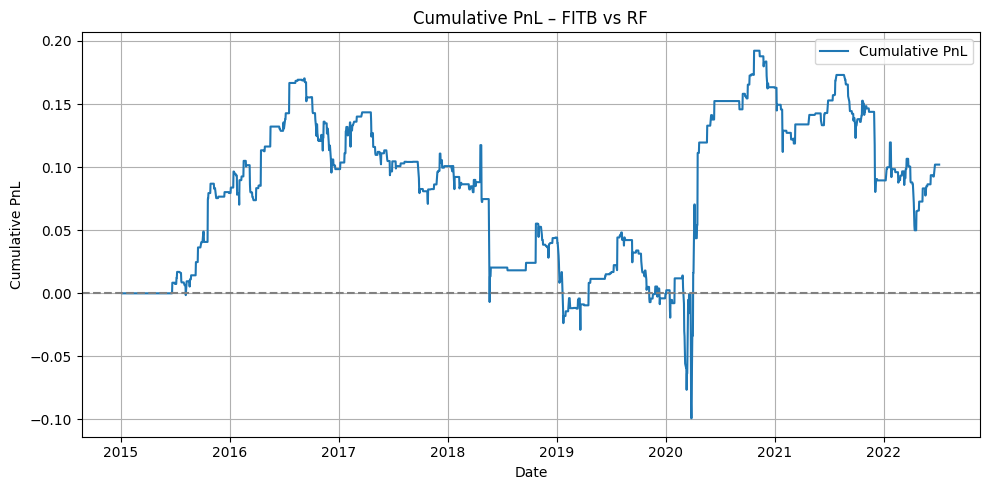

In [ ]:
#Step 11) PnL Visualization

plt.figure(figsize=(10, 5))
plt.plot(pair_df["cumulative_pnl"], label="Cumulative PnL")
plt.axhline(0, linestyle='--', color='gray')
plt.title(f"Cumulative PnL – {T1} vs {T2}")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Step 12) Grid search parameter optimization
best_sharpe = -np.inf
best_params = None

#12a) Define parameter ranges to search over
entry_range = np.arange(1.0, 2.5, 0.1)
exit_range = np.arange(0.1, 1.0, 0.1)

#12b) grid search over all combinations
for entry in entry_range:
    for exit in exit_range:
        if exit >= entry:
            continue  # Ensure valid logic: exit must be < entry

        signal = []
        position = 0  # 1 = long spread, -1 = short spread, 0 = flat

        # Step through z-score series to generate trading signals
        for z in pair_df["z_score"]:
            if position == 0:
                if z <= -entry:
                    position = 1  # Long the spread
                elif z >= entry:
                    position = -1  # Short the spread
            elif position == 1:
                if z >= -exit:
                    position = 0  # Exit long
            elif position == -1:
                if z <= exit:
                    position = 0  # Exit short
            signal.append(position)

        # Store the signals temporarily
        pair_df["signal_tmp"] = signal

        # Compute daily PnL using lagged signal (to avoid lookahead bias)
        pnl = pair_df["signal_tmp"].shift(1) * pair_df["pair_return"]

        # Compute Sharpe ratio (annualized)
        sharpe = pnl.mean() / pnl.std() * np.sqrt(252)

        # Update best Sharpe and parameters if this combo is better
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_params = (entry, exit)

# Final output
print(f"Best Sharpe: {best_sharpe:.2f}")
print(f"Entry Threshold: {best_params[0]:.2f}")
print(f"Exit Threshold:  {best_params[1]:.2f}")

Best Sharpe: 0.16
Entry Threshold: 1.10
Exit Threshold:  0.50


In [ ]:
#Step 13) ML Dataset Construction

#13a) Make a copy of pair_df to work on
ml_df = pair_df.copy()

# 13b) Feature Engineering
ml_df["z_score_lag1"] = ml_df["z_score"].shift(1)
ml_df["z_score_lag2"] = ml_df["z_score"].shift(2)
ml_df["spread_change"] = ml_df["Spread"].diff()
ml_df["spread_vol"] = ml_df["Spread"].rolling(20).std()

# 13c) Label Construction
ml_df["z_score_lead"] = ml_df["z_score"].shift(-1)
ml_df["label"] = (ml_df["z_score_lead"].abs() < ml_df["z_score"].abs()).astype(int)

# 13d) Drop rows with any NaNs (from lags, rolling window, or lead)
ml_df = ml_df.dropna()

# Define feature columns
feature_cols = [
    "z_score", "z_score_lag1", "z_score_lag2",
    "spread_change", "spread_vol"
]

# Features and labels
X = ml_df[feature_cols]
y = ml_df["label"]

# 13e) Time-based Train/Val/Test Split
n = len(ml_df)
X_train, y_train = X.iloc[:int(n*0.7)], y.iloc[:int(n*0.7)]
X_val,   y_val   = X.iloc[int(n*0.7):int(n*0.9)], y.iloc[int(n*0.7):int(n*0.9)]
X_test,  y_test  = X.iloc[int(n*0.9):], y.iloc[int(n*0.9):]

In [ ]:
#Step 14) ML Feature Engineering & Model Training

from xgboost import XGBClassifier

# 14a) Add ML features
pair_df["z_score_lag1"] = pair_df["z_score"].shift(1)
pair_df["z_score_lag2"] = pair_df["z_score"].shift(2)
pair_df["spread_change"] = pair_df["Spread"].diff()
pair_df["spread_vol"] = pair_df["Spread"].rolling(window=10).std()

# 14b) Create binary label: 1 if spread increases tomorrow, 0 if not
pair_df["label"] = (pair_df["Spread"].shift(-1) > pair_df["Spread"]).astype(int)

# 14c) Drop rows with NaNs from lag/rolling features
pair_df = pair_df.dropna(subset=["z_score", "z_score_lag1", "z_score_lag2", "spread_change", "spread_vol", "label"])

n = len(pair_df)
train_df = pair_df.iloc[:int(0.7 * n)]
val_df   = pair_df.iloc[int(0.7 * n):int(0.9 * n)]
test_df  = pair_df.iloc[int(0.9 * n):]

# 14d) Define feature columns and target
features = ["z_score", "z_score_lag1", "z_score_lag2", "spread_change", "spread_vol"]
target = "label"

X_train = train_df[features]
y_train = train_df[target]
X_val   = val_df[features]
y_val   = val_df[target]
X_test = test_df [features]
y_test = test_df[target]

# 14e) Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 14f) Evaluate
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
test_acc = model.score(X_test,y_test)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:28:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 1.00
Validation Accuracy: 0.70
Test Accuracy: 0.73


In [ ]:
#Step 15 1.0)
from sklearn.metrics import classification_report

# 15a) Predict on validation and test sets
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# 15b) Convert predicted labels to trading signals:
# 1 = Long, -1=Short, 0=No position
val_df["ml_signal"] = np.where(val_pred == 1, 1, np.where(val_pred == -1, -1, 0))
test_df["ml_signal"] = np.where(test_pred == 1, 1, np.where(test_pred == -1, -1, 0))

# 15c) Compute PnL for validation and test sets
val_df["ml_pnl"] = val_df["ml_signal"].shift(1) * val_df["pair_return"]
test_df["ml_pnl"] = test_df["ml_signal"].shift(1) * test_df["pair_return"]

val_df["ml_cum_pnl"] = val_df["ml_pnl"].cumsum()
test_df["ml_cum_pnl"] = test_df["ml_pnl"].cumsum()

# 15d) Calculate Sharpe Ratios
val_mean = val_df["ml_pnl"].mean()
val_std = val_df["ml_pnl"].std()
val_sharpe = val_mean / val_std * np.sqrt(252)

test_mean = test_df["ml_pnl"].mean()
test_std = test_df["ml_pnl"].std()
test_sharpe = test_mean / test_std * np.sqrt(252)

# Print results
print(f"Validation Sharpe Ratio: {val_sharpe:.2f}")
print(f"Test Sharpe Ratio: {test_sharpe:.2f}")
print(f"Final Cumulative PnL on Validation: {val_df['ml_cum_pnl'].iloc[-1]:.4f}")
print(f"Final Cumulative PnL on Test: {test_df['ml_cum_pnl'].iloc[-1]:.4f}")


Validation Sharpe Ratio: -0.35
Test Sharpe Ratio: -0.51
Final Cumulative PnL on Validation: -0.0455
Final Cumulative PnL on Test: -0.0360


/tmp/ipython-input-904650603.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["ml_signal"] = np.where(val_pred == 1, 1, np.where(val_pred == -1, -1, 0))
/tmp/ipython-input-904650603.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["ml_signal"] = np.where(test_pred == 1, 1, np.where(test_pred == -1, -1, 0))
/tmp/ipython-input-904650603.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [ ]:
#Step 15 2.0)
from xgboost import XGBClassifier
import numpy as np

# 15a) Predict labels (direction)
val_pred  = model.predict(X_val)
test_pred = model.predict(X_test)

# 15b) Convert predictions to signals: 1=long, -1=short, 0=flat
val_df["ml_signal"] = np.where(val_pred == 1, 1, np.where(val_pred == -1, -1, 0))
test_df["ml_signal"] = np.where(test_pred == 1, 1, np.where(test_pred == -1, -1, 0))

# 15c) Compute PnL from ML signals
val_df.loc[:, "ml_pnl"] = val_df["ml_signal"].shift(1) * val_df["pair_return"]
test_df.loc[:, "ml_pnl"] = test_df["ml_signal"].shift(1) * test_df["pair_return"]

val_df.loc[:, "ml_cum_pnl"] = val_df["ml_pnl"].cumsum()
test_df.loc[:, "ml_cum_pnl"] = test_df["ml_pnl"].cumsum()

# 15d) Evaluate
val_sharpe = val_df["ml_pnl"].mean() / val_df["ml_pnl"].std() * np.sqrt(252)
test_sharpe = test_df["ml_pnl"].mean() / test_df["ml_pnl"].std() * np.sqrt(252)

print(f"\nValidation Sharpe Ratio: {val_sharpe:.2f}")
print(f"Test Sharpe Ratio: {test_sharpe:.2f}")
print(f"Final Cumulative PnL on Validation: {val_df['ml_cum_pnl'].iloc[-1]:.4f}")
print(f"Final Cumulative PnL on Test: {test_df['ml_cum_pnl'].iloc[-1]:.4f}")


Validation Sharpe Ratio: -0.35
Test Sharpe Ratio: -0.51
Final Cumulative PnL on Validation: -0.0455
Final Cumulative PnL on Test: -0.0360


/tmp/ipython-input-1327008441.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["ml_signal"] = np.where(val_pred == 1, 1, np.where(val_pred == -1, -1, 0))
/tmp/ipython-input-1327008441.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["ml_signal"] = np.where(test_pred == 1, 1, np.where(test_pred == -1, -1, 0))


In [ ]:
#Step 15 3.0
from xgboost import XGBClassifier
import numpy as np

# 15a) Predict labels (direction)
val_pred  = model.predict(X_val)
test_pred = model.predict(X_test)

# 15b) Convert predictions to signals: 1=long, -1=short, 0=flat
from scipy.special import logit

# Clip predicted probabilities to avoid logit issues
eps = 1e-6
k = 1.0  # sensitivity scaling factor

probs_val = model.predict_proba(X_val)[:, 1]
probs_test = model.predict_proba(X_test)[:, 1]

val_probs_clipped = np.clip(probs_val, eps, 1 - eps)
test_probs_clipped = np.clip(probs_test, eps, 1 - eps)

val_df.loc[:, "ml_signal"] = np.tanh(k * logit(val_probs_clipped))
test_df.loc[:, "ml_signal"] = np.tanh(k * logit(test_probs_clipped))

# 15c) Compute PnL from ML signals
val_df.loc[:, "ml_pnl"] = val_df["ml_signal"].shift(1) * val_df["pair_return"]
test_df.loc[:, "ml_pnl"] = test_df["ml_signal"].shift(1) * test_df["pair_return"]

val_df.loc[:, "ml_cum_pnl"] = val_df["ml_pnl"].cumsum()
test_df.loc[:, "ml_cum_pnl"] = test_df["ml_pnl"].cumsum()

# 15d) Evaluate
val_sharpe = val_df["ml_pnl"].mean() / val_df["ml_pnl"].std() * np.sqrt(252)
test_sharpe = test_df["ml_pnl"].mean() / test_df["ml_pnl"].std() * np.sqrt(252)

print(f"\nValidation Sharpe Ratio: {val_sharpe:.2f}")
print(f"Test Sharpe Ratio: {test_sharpe:.2f}")
print(f"Final Cumulative PnL on Validation: {val_df['ml_cum_pnl'].iloc[-1]:.4f}")
print(f"Final Cumulative PnL on Test: {test_df['ml_cum_pnl'].iloc[-1]:.4f}")


Validation Sharpe Ratio: -0.97
Test Sharpe Ratio: 0.12
Final Cumulative PnL on Validation: -0.1638
Final Cumulative PnL on Test: 0.0103


/tmp/ipython-input-2705574431.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.61088955  0.17150477  0.95729995 -0.97640795 -0.24620914 -0.9996381
  0.61647874  0.99999356 -0.9970008   0.99010384 -0.99209267 -0.9999999
  0.94712174 -0.9999727  -0.20066822  0.9994      0.99774325 -0.9985689
 -0.9810938   0.9968349   0.13167314 -0.99758506  0.9994692  -0.99431276
 -0.8839176  -0.4959599  -0.6635196   0.99930906  0.99254113 -0.77438754
  0.99921995 -0.9994022   0.9345354   0.98926336 -0.86783713 -0.6459382
 -0.99988306  0.5176449   0.9985381  -0.984918    0.97374856  0.39719883
 -0.6453753  -0.3777594   0.1677964   0.9975354  -0.99810475 -0.99849695
  0.90893203  0.49772242 -0.99124515  0.95385736 -0.8924547  -0.21362953
  0.0407686  -0.9380524   0.9117015   0.07086276  0.9509868   0.99840647
 -0.0994055   0.15955628  0.8962047   0.9995685  -0.98961586 -0.03460348
  0.9005482  -0.9678     -0.22195414 -0.254314